In [1]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import random
import matplotlib
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 导入之前实验的数据和MINST数据
xls_path = 'E:\\Phd\\Research\\Experiments\\0416\\data.xlsx'
df = pd.read_excel(xls_path, sheet_name = None)

(_, _), (x1_test, y1_test) = mnist.load_data()
x1_t = x1_test.reshape(10000, 784)

In [3]:
# 加载Fashion-MNIST数据集
(x2_train, y2_train), (x2_test, y2_test) = fashion_mnist.load_data()
x2_all = x2_train.reshape(60000, 784)

### 实验1-2：替换 部分MNIST样本 为 Fashion-MNIST其他样本 
### 实验1-2-1：N=5000，R = 0%， 5%， 40%
* 获取不同替换比例R对应的一维数据分布

In [24]:
# 提取df中相关实验数据
x1 = df['x1'].to_numpy()
x1_5f = df['x1_5f'].to_numpy()

res_0 = df['res']['res_0'].to_numpy().reshape(-1, 1)
res_5f = df['res']['res_5f'].to_numpy().reshape(-1, 1)

label_x1 = df['label']['label_x1'].to_numpy()
label_x1_5f = df['label']['label_x1_5f'].to_numpy()

ind_r5m = df['index']['ind_r5m'].to_numpy().tolist()

In [25]:
"""获得R=0%时x1降维后的一维分布"""
# 使用网格搜索交叉验证来优化带宽
params_0 = {'bandwidth': np.logspace(-1, 3, 40)}
grid_0 = GridSearchCV(KernelDensity(), params_0)
grid_0.fit(res_0)
print("best bandwidth 1d: {0}".format(grid_0.best_estimator_.bandwidth))

# 使用最佳估计器来计算核密度估计
kde_0 = grid_0.best_estimator_

best bandwidth 1d: 46.41588833612777


In [26]:
"""获得R=5%时x1降维后的一维分布"""
# 使用网格搜索交叉验证来优化带宽
params_5f = {'bandwidth': np.logspace(-1, 3, 40)}
grid_5f = GridSearchCV(KernelDensity(), params_5f)
grid_5f.fit(res_5f)
print("best bandwidth 1d: {0}".format(grid_5f.best_estimator_.bandwidth))

# 使用最佳估计器来计算核密度估计
kde_5f = grid_5f.best_estimator_

best bandwidth 1d: 46.41588833612777


In [17]:
"""获得R=40%时x1降维后的一维分布"""
ind_5f = list(filter(lambda x: x not in ind_r5m, range(5000))) # x1_5f中原始元素对应x1中的索引
ind_a40f = random.sample(ind_5f, int(0.35*len(x1))) # x1_40f相对x1_5f新增被替换元素对应x1中的索引
ind_r40f = ind_r5m + ind_a40f # x1_40f中所有被替换的元素对应x1中的索引
x1_40f = x1_5f
x1_40f[ind_a40f] = x1_t[len(ind_r5m):len(ind_r40f)]

pca_40f = PCA(n_components=1, whiten=False)
res_40f = pca_40f.fit_transform(x1_40f)

# 使用网格搜索交叉验证来优化带宽
params_40f = {'bandwidth': np.logspace(-1, 3, 40)}
grid_40f = GridSearchCV(KernelDensity(), params_40f)
grid_40f.fit(res_40f)
print("best bandwidth 1d: {0}".format(grid_40f.best_estimator_.bandwidth))

# 使用最佳估计器来计算核密度估计
kde_40f = grid_40f.best_estimator_

best bandwidth 1d: 74.43803013251689


#### a) 不同一维分布的可视化对比

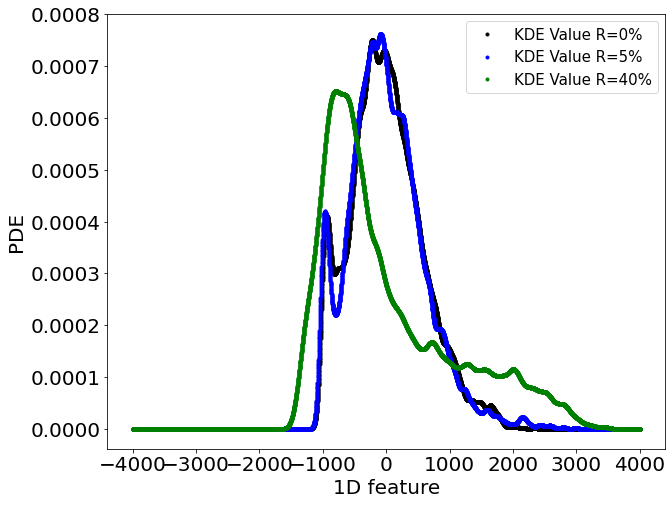

In [28]:
xplot = np.linspace(-4000, 4000, 8000).reshape(-1,1)
dens_0 = kde_0.score_samples(xplot)  # 返回的是点对应概率密度的log值，需要使用exp求指数还原
dens_5f = kde_5f.score_samples(xplot)
dens_40f = kde_40f.score_samples(xplot)

plt.figure(figsize = (10, 8))  # 设置画布大小
plt.plot(xplot, np.exp(dens_0), marker='.', linewidth=0.01, c="k", label='KDE Value R=0%')
plt.plot(xplot, np.exp(dens_5f), marker='.', linewidth=0.01, c="b", label='KDE Value R=5%')
plt.plot(xplot, np.exp(dens_40f), marker='.', linewidth=0.01, c="g", label='KDE Value R=40%')
plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('1D feature', font)
plt.ylabel('PDE', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

#### b) 1D特征区间\[-1000, -500\]对应样本数据的对比（R = 0% vs 5%）

In [ ]:
"""可视化所选取的区间"""
plt.figure(figsize = (10, 8))  # 设置画布大小
plt.plot(xplot, np.exp(dens_0), marker='.', linewidth=1e-10, c="k", label='KDE Value R=0%')
plt.plot(xplot, np.exp(dens_5m), marker='.', linewidth=1e-10, c="b", label='KDE Value R=5%')

px_0 = [-1000] * 20 + [-500] * 20
py_0 = list(np.linspace(0, np.exp(kde_0.score_samples([[-1000]])[0]), 20)) + list(np.linspace(0, np.exp(kde_0.score_samples([[-500]])[0]), 20))

px_5m = [-1000] * 20 + [-500] * 20
py_5m = list(np.linspace(0, np.exp(kde_5m.score_samples([[-1000]])[0]), 20)) + list(np.linspace(0, np.exp(kde_5m.score_samples([[-500]])[0]), 20))

plt.plot(px_0, py_0, marker='.', linewidth=1e-5, c="y", label='Interval R=0%')
plt.plot(px_5m, py_5m, marker='.', linewidth=1e-5, c="m", label='Interval R=5%')

plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('1D feature', font)
plt.ylabel('PDE', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

In [ ]:
"""R=0%时[-1000, -500)对应的样本类别统计"""
ind_int = np.array([i for (i,x) in enumerate(res_0.flatten().tolist()) if -1000 <= x < -500])
ind_int_m = np.array(ind)[ind_int] # 对应在x1_all中的索引
num_int_m = ind_int_m.shape[0]
label_int_m = y1_train[ind_int_m]
num_int_m0 = label_int_m.tolist().count(0)
num_int_m1 = label_int_m.tolist().count(1)
num_int_m2 = label_int_m.tolist().count(2)
num_int_m3 = label_int_m.tolist().count(3)
num_int_m4 = label_int_m.tolist().count(4)
num_int_m5 = label_int_m.tolist().count(5)
num_int_m6 = label_int_m.tolist().count(6)
num_int_m7 = label_int_m.tolist().count(7)
num_int_m8 = label_int_m.tolist().count(8)
num_int_m9 = label_int_m.tolist().count(9)

In [ ]:
"""R=5%时被替换掉的[-1000, -500)样本对应的样本类别统计"""
ind_int_r5 = np.array([i for (i,x) in enumerate(res_0[ind_r5m].flatten().tolist()) if -1000 <= x < -500]) # 所求样本在ind_r5m索引对应数组切片中的索引
ind_int_r5m = np.array(ind)[np.array(ind_r5m)[ind_int_r5]] # 对应在x1_all中的索引
num_int_r5 = ind_int_r5m.shape[0]
label_int_r5 = y1_train[ind_int_r5m]
num_int_r5m0 = label_int_r5.tolist().count(0)
num_int_r5m1 = label_int_r5.tolist().count(1)
num_int_r5m2 = label_int_r5.tolist().count(2)
num_int_r5m3 = label_int_r5.tolist().count(3)
num_int_r5m4 = label_int_r5.tolist().count(4)
num_int_r5m5 = label_int_r5.tolist().count(5)
num_int_r5m6 = label_int_r5.tolist().count(6)
num_int_r5m7 = label_int_r5.tolist().count(7)
num_int_r5m8 = label_int_r5.tolist().count(8)
num_int_r5m9 = label_int_r5.tolist().count(9)

In [ ]:
"""R=5%时新添的[-1000, -500]中样本对应的样本类别统计"""
ind_int_r5mt = np.array([i for (i,x) in enumerate(res_5m[ind_r5m].flatten().tolist()) if -1000 <= x < -500]) # 所求样本在ind_r5m索引对应数组切片中的索引
num_int_r5mt = ind_int_r5mt.shape[0]
label_int_r5mt = y1_test[ind_int_r5mt]
num_int_r5mt0 = label_int_r5mt.tolist().count(0)
num_int_r5mt1 = label_int_r5mt.tolist().count(1)
num_int_r5mt2 = label_int_r5mt.tolist().count(2)
num_int_r5mt3 = label_int_r5mt.tolist().count(3)
num_int_r5mt4 = label_int_r5mt.tolist().count(4)
num_int_r5mt5 = label_int_r5mt.tolist().count(5)
num_int_r5mt6 = label_int_r5mt.tolist().count(6)
num_int_r5mt7 = label_int_r5mt.tolist().count(7)
num_int_r5mt8 = label_int_r5mt.tolist().count(8)
num_int_r5mt9 = label_int_r5mt.tolist().count(9)

#### b) 1D特征区间\[-1000, -500)和\[0, 500)对应样本数据的对比（R = 0% vs 5%）
##### \[-1000, -500)对应样本数据的对比（R = 0% vs 5%）

In [ ]:
"""可视化所选取的区间"""
plt.figure(figsize = (10, 8))  # 设置画布大小
plt.plot(xplot, np.exp(dens_0), marker='.', linewidth=1e-10, c="k", label='KDE Value R=0%')
plt.plot(xplot, np.exp(dens_5f), marker='.', linewidth=1e-10, c="b", label='KDE Value R=5%')

# [-1000, -500)区间
px_0 = [-1000] * 20 + [-500] * 20
py_0 = list(np.linspace(0, np.exp(kde_0.score_samples([[-1000]])[0]), 20)) + list(np.linspace(0, np.exp(kde_0.score_samples([[-500]])[0]), 20))

px_5f = [-1000] * 20 + [-500] * 20
py_5f = list(np.linspace(0, np.exp(kde_5f.score_samples([[-1000]])[0]), 20)) + list(np.linspace(0, np.exp(kde_5f.score_samples([[-500]])[0]), 20))

plt.plot(px_0, py_0, marker='.', linewidth=1e-5, c="y", label='[-1000, -500) R=0%')
plt.plot(px_5f, py_5f, marker='.', linewidth=1e-5, c="m", label='[-1000, -500) R=5%')

# [0, 500)区间
px_0 = [0] * 20 + [500] * 20
py_0 = list(np.linspace(0, np.exp(kde_0.score_samples([[0]])[0]), 20)) + list(np.linspace(0, np.exp(kde_0.score_samples([[500]])[0]), 20))

px_5f = [0] * 20 + [500] * 20
py_5f = list(np.linspace(0, np.exp(kde_5f.score_samples([[0]])[0]), 20)) + list(np.linspace(0, np.exp(kde_5f.score_samples([[500]])[0]), 20))

plt.plot(px_0, py_0, marker='.', linewidth=1e-5, c="g", label='[0, 500) R=0%')
plt.plot(px_5f, py_5f, marker='.', linewidth=1e-5, c="c", label='[0, 500) R=5%')


plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('1D feature', font)
plt.ylabel('PDE', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

* 计算打印分析统计数据

In [ ]:
"""R=5%时新添的[-1000, -500]中样本对应的样本类别统计"""
ind_int_r5f = np.array([i for (i,x) in enumerate(res_5f[ind_r5m].flatten().tolist()) if -1000 <= x < -500]) # 在ind_r5m数组切片上的索引
num_int_r5f = ind_int_r5f.shape[0]
label_int_r5f = y2_train[ind_int_r5f]
num_int_r5f0 = label_int_r5f.tolist().count(0)
num_int_r5f1 = label_int_r5f.tolist().count(1)
num_int_r5f2 = label_int_r5f.tolist().count(2)
num_int_r5f3 = label_int_r5f.tolist().count(3)
num_int_r5f4 = label_int_r5f.tolist().count(4)
num_int_r5f5 = label_int_r5f.tolist().count(5)
num_int_r5f6 = label_int_r5f.tolist().count(6)
num_int_r5f7 = label_int_r5f.tolist().count(7)
num_int_r5f8 = label_int_r5f.tolist().count(8)
num_int_r5f9 = label_int_r5f.tolist().count(9)

In [ ]:
# [-1000, -500)中总样本统计
print(num_int_m, num_int_m0, num_int_m1, num_int_m2, num_int_m3, num_int_m4, num_int_m5, num_int_m6, num_int_m7, num_int_m8, num_int_m9)
# [-1000, -500)中被替换样本统计
print(num_int_r5, num_int_r5m0, num_int_r5m1, num_int_r5m2, num_int_r5m3, num_int_r5m4, num_int_r5m5, num_int_r5m6, num_int_r5m7, num_int_r5m8, num_int_r5m9)
# [-1000, -500)中MNIST替换样本统计
print(num_int_r5mt, num_int_r5mt0, num_int_r5mt1, num_int_r5mt2, num_int_r5mt3, num_int_r5mt4, num_int_r5mt5, num_int_r5mt6, num_int_r5mt7, num_int_r5mt8, num_int_r5mt9)
# [-1000, -500)中FASHION替换样本统计
print(num_int_r5f, num_int_r5f0, num_int_r5f1, num_int_r5f2, num_int_r5f3, num_int_r5f4, num_int_r5f5, num_int_r5f6, num_int_r5f7, num_int_r5f8, num_int_r5f9)

* 可视化样本类别变化

In [ ]:
matplotlib.rcParams['font.family']=["DengXian", "sans-serif"]

labels = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
#orig_means= [0, 498, 41, 26, 58, 24, 21, 126, 27, 81]
mnist_means = [0, 32, 3, 2, 7, 0, 1, 9, 1, 3]
fashion_means = [0, 0, 0, 0, 0, 2, 0, 0, 0, 0]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

#rects1 = ax.bar(x - width, orig_means, width, label='[-1000, -500)样本')
rects2 = ax.bar(x - width/2, mnist_means, width, label='被替换MNIST样本')
rects3 = ax.bar(x + width/2, fashion_means, width, label='新添FASHION样本')

ax.set_ylabel('样本数')
ax.set_title('[-1000, -500)替换前后样本类别统计')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

##### \[-1000, -500)对应样本数据的对比（R = 0% vs 5%）
* 计算打印分析统计数据

In [ ]:
"""R=0%时[0, 500)对应的样本类别统计"""
ind_int1 = np.array([i for (i,x) in enumerate(res_0.flatten().tolist()) if 0 <= x < 500])
ind_int1_m = np.array(ind)[ind_int1] # 对应在x1_all中的索引
num_int1_m = ind_int1_m.shape[0]
label_int1_m = y1_train[ind_int1_m]
num_int1_m0 = label_int1_m.tolist().count(0)
num_int1_m1 = label_int1_m.tolist().count(1)
num_int1_m2 = label_int1_m.tolist().count(2)
num_int1_m3 = label_int1_m.tolist().count(3)
num_int1_m4 = label_int1_m.tolist().count(4)
num_int1_m5 = label_int1_m.tolist().count(5)
num_int1_m6 = label_int1_m.tolist().count(6)
num_int1_m7 = label_int1_m.tolist().count(7)
num_int1_m8 = label_int1_m.tolist().count(8)
num_int1_m9 = label_int1_m.tolist().count(9)

In [ ]:
"""R=5%时被替换掉的[0, 500)样本对应的样本类别统计"""
ind_int1_r5 = np.array([i for (i,x) in enumerate(res_0[ind_r5m].flatten().tolist()) if 0 <= x < 500]) # 所求样本在ind_r5m索引对应数组切片中的索引
ind_int1_r5m = np.array(ind)[np.array(ind_r5m)[ind_int1_r5]] # 对应在x1_all中的索引
num_int1_r5 = ind_int1_r5m.shape[0]
label_int1_r5 = y1_train[ind_int1_r5m]
num_int1_r5m0 = label_int1_r5.tolist().count(0)
num_int1_r5m1 = label_int1_r5.tolist().count(1)
num_int1_r5m2 = label_int1_r5.tolist().count(2)
num_int1_r5m3 = label_int1_r5.tolist().count(3)
num_int1_r5m4 = label_int1_r5.tolist().count(4)
num_int1_r5m5 = label_int1_r5.tolist().count(5)
num_int1_r5m6 = label_int1_r5.tolist().count(6)
num_int1_r5m7 = label_int1_r5.tolist().count(7)
num_int1_r5m8 = label_int1_r5.tolist().count(8)
num_int1_r5m9 = label_int1_r5.tolist().count(9)

In [ ]:
"""R=5%时新添的[0, 500]中样本对应的样本类别统计"""
ind_int1_r5f = np.array([i for (i,x) in enumerate(res_5f[ind_r5m].flatten().tolist()) if 0 <= x < 500]) # 在ind_r5m数组切片上的索引
num_int1_r5f = ind_int1_r5f.shape[0]
label_int1_r5f = y2_train[ind_int1_r5f]
num_int1_r5f0 = label_int1_r5f.tolist().count(0)
num_int1_r5f1 = label_int1_r5f.tolist().count(1)
num_int1_r5f2 = label_int1_r5f.tolist().count(2)
num_int1_r5f3 = label_int1_r5f.tolist().count(3)
num_int1_r5f4 = label_int1_r5f.tolist().count(4)
num_int1_r5f5 = label_int1_r5f.tolist().count(5)
num_int1_r5f6 = label_int1_r5f.tolist().count(6)
num_int1_r5f7 = label_int1_r5f.tolist().count(7)
num_int1_r5f8 = label_int1_r5f.tolist().count(8)
num_int1_r5f9 = label_int1_r5f.tolist().count(9)

In [ ]:
# [0, 500)中总样本统计
print(num_int1_m, num_int1_m0, num_int1_m1, num_int1_m2, num_int1_m3, num_int1_m4, num_int1_m5, num_int1_m6, num_int1_m7, num_int1_m8, num_int1_m9)
# [0, 500)中被替换样本统计
print(num_int1_r5, num_int1_r5m0, num_int1_r5m1, num_int1_r5m2, num_int1_r5m3, num_int1_r5m4, num_int1_r5m5, num_int1_r5m6, num_int1_r5m7, num_int1_r5m8, num_int1_r5m9)
# [0, 500)中FASHION替换样本统计
print(num_int1_r5f, num_int1_r5f0, num_int1_r5f1, num_int1_r5f2, num_int1_r5f3, num_int1_r5f4, num_int1_r5f5, num_int1_r5f6, num_int1_r5f7, num_int1_r5f8, num_int1_r5f9)

* 可视化样本类别变化

In [ ]:
matplotlib.rcParams['font.family']=["DengXian", "sans-serif"]

labels = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
#orig_means= [0, 498, 41, 26, 58, 24, 21, 126, 27, 81]
mnist_means_int1 = [6, 0, 7, 4, 8, 8, 10, 8, 12, 8]
fashion_means_int1 = [3, 13, 3, 6, 1, 10, 4, 13, 3, 4]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig_int1, ax_int1 = plt.subplots()

#rects1 = ax.bar(x - width, orig_means, width, label='[-1000, -500)样本')
rects2_int1 = ax_int1.bar(x - width/2, mnist_means_int1, width, label='被替换MNIST样本')
rects3_int1 = ax_int1.bar(x + width/2, fashion_means_int1, width, label='新添FASHION样本')

ax_int1.set_ylabel('样本数')
ax_int1.set_title('[0, 500)替换前后样本类别统计')
ax_int1.set_xticks(x)
ax_int1.set_xticklabels(labels)
ax_int1.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax_int1.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#autolabel(rects1)
autolabel(rects2_int1)
autolabel(rects3_int1)

fig_int1.tight_layout()

### 实验1-2-2 ：N = 5000，替换MNIST vs 替换Fashion-MNIST
* R=5%，可视化替换MNIST与替换Fashion-MNIST的对比

In [ ]:
plt.figure(figsize = (10, 8))  # 设置画布大小
plt.plot(xplot, np.exp(dens_0), marker='.', linewidth=0.01, c="k", label='Baseline R=5%')
plt.plot(xplot, np.exp(dens_5m), marker='.', linewidth=0.01, c="b", label='MNIST R=5%')
plt.plot(xplot, np.exp(dens_5f), marker='.', linewidth=0.01, c="g", label='Fashion-MNIST R=5%')
plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('1D feature', font)
plt.ylabel('PDE', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

In [ ]:
plt.figure(figsize = (10, 8))  # 设置画布大小
plt.plot(xplot, np.exp(dens_0), marker='.', linewidth=0.01, c="k", label='Baseline R=0%')
plt.plot(xplot, np.exp(dens_10m), marker='.', linewidth=0.01, c="b", label='MNIST R=10%')
plt.plot(xplot, np.exp(dens_10f), marker='.', linewidth=0.01, c="g", label='Fashion-MNIST R=10%')
plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('1D feature', font)
plt.ylabel('PDE', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

In [ ]:
plt.figure(figsize = (10, 8))  # 设置画布大小
plt.plot(xplot, np.exp(dens_0), marker='.', linewidth=0.01, c="k", label='Baseline R=0%')
plt.plot(xplot, np.exp(dens_20m), marker='.', linewidth=0.01, c="b", label='MNIST R=20%')
plt.plot(xplot, np.exp(dens_20f), marker='.', linewidth=0.01, c="g", label='Fashion-MNIST R=20%')
plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('1D feature', font)
plt.ylabel('PDE', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

In [ ]:
plt.figure(figsize = (10, 8))  # 设置画布大小
plt.plot(xplot, np.exp(dens_0), marker='.', linewidth=0.01, c="k", label='Baseline R=0%')
plt.plot(xplot, np.exp(dens_40m), marker='.', linewidth=0.01, c="b", label='MNIST R=40%')
plt.plot(xplot, np.exp(dens_40f), marker='.', linewidth=0.01, c="g", label='Fashion-MNIST R=40%')
plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('1D feature', font)
plt.ylabel('PDE', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

In [ ]:
plt.figure(figsize = (10, 8))  # 设置画布大小
plt.plot(xplot, np.exp(dens_0), marker='.', linewidth=0.01, c="k", label='Baseline R=0%')
plt.plot(xplot, np.exp(dens_80m), marker='.', linewidth=0.01, c="b", label='MNIST R=80%')
plt.plot(xplot, np.exp(dens_80f), marker='.', linewidth=0.01, c="g", label='Fashion-MNIST R=80%')
plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('1D feature', font)
plt.ylabel('PDE', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

### 后续工作
* 输出保存相关数据用于后续分析

In [ ]:
df_x1 = pd.DataFrame(x1)
df_x1_5m = pd.DataFrame(x1_5m)
df_x1_5f = pd.DataFrame(x1_5f)
res = pd.DataFrame({'res_0':res_0.squeeze(), 'res_5m':res_5m.squeeze(), 'res_5f':res_5f.squeeze()})
label_x1 = y1_train[ind]
label_x1_5m = label_x1
label_x1_5m[ind_r5m] = y1_test[:len(ind_r5m)]
label_x1_5f = label_x1
label_x1_5f[ind_r5m] = y2_train[:len(ind_r5m)]
label = pd.DataFrame({'label_x1':label_x1, 'label_x1_5m':label_x1_5m, 'label_x1_5f':label_x1_5f})
index = pd.DataFrame({'ind_r5m':ind_r5m})

In [ ]:
xls_path = 'E:\\Phd\\Research\\Experiments\\0422\\data.xlsx'

with pd.ExcelWriter(xls_path) as writer:
    df_x1.to_excel(writer, sheet_name='x1', header=False, index=False)
    df_x1_5m.to_excel(writer, sheet_name='x1_5m', header=False, index=False)
    df_x1_5f.to_excel(writer, sheet_name='x1_5f', header=False, index=False)
    res.to_excel(writer, sheet_name='res', index=False)
    label.to_excel(writer, sheet_name='label', index=False)
    index.to_excel(writer, sheet_name='index', index=False)
    writer.save()

* 样本特征值

In [ ]:
# [-1000, -500)中被替换样本特征值
data_int_r5m = res_0[np.array(ind_r5m)[ind_int_r5]]
# [-1000, -500)中MNIST替换样本特征值
data_int_5mt = res_5m[np.array(ind_r5m)[ind_int_r5mt]]
# [-1000, -500)中FASHION替换样本特征值
data_int_r5f = res_5f[np.array(ind_r5m)[ind_int_r5f]]

# [0, 500)中被替换样本特征值
data_int1_r5m = res_0[np.array(ind_r5m)[ind_int1_r5]]
# [0, 500)中FASHION替换样本特征值
data_int1_r5f = res_5f[np.array(ind_r5m)[ind_int1_r5f]]

* 计算可视化KL散度

In [ ]:
KL_0_5m = scipy.stats.entropy(dens_0, dens_5m)
KL_0_5f = scipy.stats.entropy(dens_0, dens_5f)
KL_0_10m = scipy.stats.entropy(dens_0, dens_10m)
KL_0_10f = scipy.stats.entropy(dens_0, dens_10f)
KL_0_20m = scipy.stats.entropy(dens_0, dens_20m)
KL_0_20f = scipy.stats.entropy(dens_0, dens_20f)
KL_0_40m = scipy.stats.entropy(dens_0, dens_40m)
KL_0_40f = scipy.stats.entropy(dens_0, dens_40f)
KL_0_80m = scipy.stats.entropy(dens_0, dens_80m)
KL_0_80f = scipy.stats.entropy(dens_0, dens_80f)

In [ ]:
"""可视化KL散度折线图"""
xplot_KL = [0.05, 0.1, 0.2, 0.4, 0.8]
KL_m = [KL_0_5m, KL_0_10m, KL_0_20m, KL_0_40m, KL_0_80m]
KL_f = [KL_0_5f, KL_0_10f, KL_0_20f, KL_0_40f, KL_0_80f]

plt.figure(figsize = (15, 12))  # 设置画布大小
plt.plot(xplot_KL, KL_m, marker='.', linewidth=1, c="b", label='KL MNIST')
plt.plot(xplot_KL, KL_f, marker='.', linewidth=1, c="r", label='KL Fashion')

for a, b in zip(xplot_KL, KL_m):
    plt.text(a, b, (a, float('%.3f'%b)), ha='center', va='bottom', fontsize=20)
for c, d in zip(xplot_KL, KL_f):
    plt.text(c, d, (c, float('%.3f'%d)), ha='center', va='bottom', fontsize=20)

plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('Sample Substitution Ratio', font)
plt.ylabel('KL Value', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()